In [1]:
%matplotlib widget
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm as WN
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR, StepLR,ReduceLROnPlateau
import time
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
import matplotlib.patches as patches
from ipywidgets import interact
types=torch.float64
torch.set_default_dtype(types)

In [37]:
class PDE_boundary_PINN_BSDE():
    def __init__(self, eqn_config):
        self.dim=eqn_config["dim"]
        self.total_time=eqn_config["total_time"]
        self.t_max=eqn_config["t_max"]
        self.dt=eqn_config["dt"]
        self.lambd = 4.0
        #self.model=torch.compile(FF_subnet_DenseNet_BSDE(3,20))
        #self.model=FF_subnet_DenseNet_BSDE(3,20)
        self.model=DenseNet(3,1,[20,20,20,20])
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=0.001,weight_decay=0.00001)
        self.scheduler = StepLR(self.optimizer,step_size=5000,gamma=0.9)
        #self.scheduler2=ReduceLROnPlateau(self.optimizer, 'min',factor=0.8,threshold=1e-3,patience=15)
        
    def cut_path_exterior(self,X):
        xsim=X[:,0]
        ysim=X[:,1]
        icut=-1
        scut=-1
        dfin=self.dt
        for i in range(xsim.shape[0]):
            if xsim[i]<0:
                icut=i
                scut=1
                break
            elif ysim[i]>1:
                icut=i
                scut=2
                break
            elif xsim[i]>1:
                icut=i
                scut=3
                break
            elif ysim[i]<0:
                icut=i
                scut=4
                break
        if scut==1:
            dtf=-xsim[icut-1]/(xsim[icut]-xsim[icut-1])
            xsim[icut]=0.0
            ysim[icut]=(ysim[icut]-ysim[icut-1])*dtf+ysim[icut-1]
            return xsim[:icut+1],ysim[:icut+1],dtf*dfin
        elif scut==2:
            dtf=(1.0-ysim[icut-1])/(ysim[icut]-ysim[icut-1])
            xsim[icut]=(xsim[icut]-xsim[icut-1])*dtf+xsim[icut-1]
            ysim[icut]=1.0
            return xsim[:icut+1],ysim[:icut+1],dtf*dfin
        elif scut==3:
            dtf=(1.0-xsim[icut-1])/(xsim[icut]-xsim[icut-1])
            xsim[icut]=1.0
            ysim[icut]=(ysim[icut]-ysim[icut-1])*dtf+ysim[icut-1]
            return xsim[:icut+1],ysim[:icut+1],dtf*dfin
        elif scut==4:
            dtf=(-ysim[icut-1])/(ysim[icut]-ysim[icut-1])
            xsim[icut]=(xsim[icut]-xsim[icut-1])*dtf+xsim[icut-1]
            ysim[icut]=0.0
            return xsim[:icut+1],ysim[:icut+1],dtf*dfin
        return xsim,ysim,dfin
            
                
    def simulate_interior_path(self,t0,X0):
        if t0>self.total_time-self.dt:
            t0-=2*self.dt
        tsim=int((self.total_time-t0)/self.dt)
        N=min(self.t_max,tsim)+2
        #xsim=np.cumsum(np.concatenate(([X0[0]],np.random.normal(loc=0,scale=np.sqrt(self.dt),size=N))))
        #ysim=np.cumsum(np.concatenate(([X0[1]],np.random.normal(loc=0,scale=np.sqrt(self.dt),size=N))))
        xis=np.random.normal(loc=0,scale=1,size=(N-1,self.dim))
        X=np.zeros((N,self.dim))
        
        X[0]=X0
        X[1:]=np.sqrt(self.dt)*xis
        X=np.cumsum(X,axis=0)
        
        xsim,ysim,dffin=self.cut_path_exterior(X)
        ts=np.linspace(t0,t0+self.dt*(xsim.shape[0]-1),xsim.shape[0])
        ts[-1]=ts[-1]-self.dt+dffin
        path=np.stack((ts,xsim,ysim),axis=1)
        return path,xis[:xsim.shape[0]-1],dffin
                
        
    def interior_sample(self,num_sample):
        #t=np.random.uniform(low=0,high=self.total_time,size=[num_sample,1])
        #x=np.random.uniform(size=(num_sample,self.dim))
        samples=[]
        xis=[]
        dfins=[]
        for _ in range(num_sample):
            path,xiss,dffin=self.simulate_interior_path(np.random.uniform(),np.random.uniform(size=self.dim))
            samples.append(torch.tensor(path,requires_grad=True))
            xis.append(torch.tensor(xiss,requires_grad=True))
            dfins.append(dffin)
        return samples,xis,dfins
    
    def dirichlet_sample(self,num_sample):
        t=np.random.uniform(low=0,high=self.total_time,size=[num_sample,1])
        x=np.stack((np.ones(num_sample),np.random.uniform(size=num_sample)*0.2),axis=1)
        return torch.tensor(np.hstack((t,x)),requires_grad=True)
    
    def neumann_sample(self,num_sample):
        Ns=int(num_sample/4)
        iz=np.stack((np.zeros(Ns),np.random.uniform(size=Ns)),axis=1)
        niz=np.repeat([[1.0,0.0]],Ns,0)
        up=np.stack((np.random.uniform(size=Ns),np.ones(Ns)),axis=1)
        nup=np.repeat([[0.0,1.0]],Ns,0)
        down=np.stack((np.random.uniform(size=Ns),np.zeros(Ns)),axis=1)
        ndown=np.repeat([[0.0,-1.0]],Ns,0)
        der=np.stack((np.ones(Ns),0.2+np.random.uniform(size=Ns)*0.8),axis=1)
        nder=np.repeat([[-1.0,0.0]],Ns,0)
        x=np.concatenate((iz,up,down,der))
        t=np.random.uniform(low=0,high=self.total_time,size=[x.shape[0],1])
        return torch.tensor(np.hstack((t,x)),requires_grad=True),torch.tensor(np.concatenate((niz,nup,ndown,nder)))
    
    def terminal_sample(self,num_sample):
        T=np.ones(shape=[num_sample,1])*self.total_time
        x=np.random.uniform(size=[num_sample,self.dim])
        return torch.tensor(np.hstack((T,x)),requires_grad=True)
    
    def interior_loss(self,interior_sample):
        samples,xis,dfins=interior_sample
        err=0.0
        for i in range(len(samples)):
            V=self.model(samples[i])
            dV=torch.autograd.grad(V,samples[i], grad_outputs=torch.ones_like(V),retain_graph=True,create_graph=True,only_inputs=True)[0]
            V_x=dV[:,1:]
            term1=np.sqrt(self.dt)*torch.sum(V_x[:-2]*xis[i][:-1])+torch.sum(V_x[-1]*xis[i][-1]*np.sqrt(dfins[i]))
            term2=-self.dt*(self.lambd*torch.sum(V_x[:-2]*V_x[:-2])+torch.sum(V_x[-1]*V_x[-1]*dfins[i])+1)
            err+=torch.square(V[-1]-V[0]-term1+term2)
        return err/len(samples)
        
    def loss(self,interior_sample,neumann_sample,dirichlet_sample,terminal_sample):
        
        L1=self.interior_loss(interior_sample)
        
        x_neumann,n_neumann=neumann_sample
        Vn=self.model(x_neumann)
        dVn=torch.autograd.grad(Vn,x_neumann, grad_outputs=torch.ones_like(Vn),retain_graph=True,create_graph=True,only_inputs=True)[0]
        V_nx=dVn[:,1:]
        normaldVn=torch.sum(V_nx*n_neumann,axis=1)
        L2=torch.mean(torch.square(normaldVn-self.h_n(x_neumann)))
        
        Vd=self.model(dirichlet_sample)
        L3=torch.mean(torch.square(Vd-self.h_d(dirichlet_sample)))
        
        Vter=self.model(terminal_sample)
        L4=torch.mean(torch.square(Vter-self.g_Tf(terminal_sample)))
        
        return 10*L1+L2+L3+L4
    
    def h_n(self,x):
        """Neumann boundary condition"""
        return torch.zeros(x.shape[0])
    
    def h_d(self,x):
        """Dirichlet boundary condition"""
        return -0.0*torch.ones(x.shape[0])
    
    def g_Tf(self,x):
        """Terminal condition"""
        lens=x[:,1:]-torch.tensor(np.repeat([[1.0,0.05]],x.shape[0],0))
        #return torch.zeros(x.shape[0])
        return torch.sqrt(torch.sum(lens*lens,axis=1))
        
    def Lv(self, x, V_t,V_x,V_xx):
        #return V_t-0.5*torch.sum(V_xx,axis=1)
        return V_t+torch.sum(V_xx,axis=1)-self.lambd*torch.sum(V_x*V_x,axis=1)
    
    def train(self,Nsteps):
        start_time = time.time()
        training_history = []
        interior_valid = self.interior_sample(256)
        neumann_valid= self.neumann_sample(40)
        dirichlet_valid=self.dirichlet_sample(40)
        terminal_valid=self.terminal_sample(40)

        # begin sgd iteration
        for step in range(Nsteps+1):
            #print(step)
            interior = self.interior_sample(200)
            neumann= self.neumann_sample(50)
            dirichlet=self.dirichlet_sample(50)
            terminal=self.terminal_sample(50)
            loss=self.loss(interior,neumann,dirichlet,terminal)
            self.optimizer.zero_grad(set_to_none=True)
            loss.backward()
            for _ in range(2):
                
                self.optimizer.step()
                self.scheduler.step()
            
            #print(step)
            if step % 100==0:
                #self.scheduler2.step()
                loss = self.loss(interior_valid,neumann_valid,dirichlet_valid,terminal_valid).detach().numpy()
                #y_init = self.y_0.detach().numpy()[0]
                elapsed_time = time.time() - start_time
                training_history.append([step, loss, elapsed_time])
                print("Epoch ",step," time ", elapsed_time," loss ", loss)

        return np.array(training_history)
    def save_model(self,file_name):
        torch.save(self.model.state_dict(), file_name)
    def load_model(self,file_name):
        self.model.load_state_dict(torch.load(file_name))
    

In [38]:
class DenseNet(nn.Module):
    def __init__(self, d_in, d_out, arch=[30, 30], seed=42):
        super(DenseNet, self).__init__()
        torch.manual_seed(seed)
        self.nn_dims = [d_in] + arch + [d_out]
        self.W = [item for sublist in
                  [[torch.nn.Parameter(torch.randn(sum(self.nn_dims[:i + 1]), self.nn_dims[i + 1],
                                             requires_grad=True) * 0.1),
                    torch.nn.Parameter(torch.zeros(self.nn_dims[i + 1], requires_grad=True))] for
                   i in range(len(self.nn_dims) - 1)]
                  for item in sublist]

        for i, w in enumerate(self.W):
            self.register_parameter('param %d' % i, w)

        #self.optim = pt.optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        for i in range(len(self.nn_dims) - 1):
            if i == len(self.nn_dims) - 2:
                x = torch.matmul(x, self.W[2 * i]) + self.W[2 * i + 1]
            else:
                x = torch.cat([x, torch.nn.functional.relu(torch.matmul(x, self.W[2 * i])
                                                     + self.W[2 * i + 1]) ** 2], dim=1)
        return x

class FF_subnet_DenseNet_BSDE(nn.Module):
    def __init__(self, dim,width):
        super(FF_subnet_DenseNet_BSDE, self).__init__()
        self.l1=nn.Linear(dim,width,bias=False)
        self.l2=nn.Linear(dim+width,width,bias=False)
        self.l3=nn.Linear(dim+2*width,width,bias=False)
        self.l4=nn.Linear(dim+3*width,1,bias=False)
    def forward(self,x):
        y2=F.relu(self.l1(x))
        x2=torch.hstack((x,y2))
        y3=F.relu(self.l2(x2))
        x3=torch.hstack((x2,y3))
        y4=F.relu(self.l3(x3))
        x4=torch.hstack((x3,y4))
        return self.l4(x4)

In [41]:
pde= PDE_boundary_PINN_BSDE({"dim":2,"total_time":1.0,"t_max":20,"dt":0.001})

In [42]:
pde.train(500)

Epoch  0  time  0.3438413143157959  loss  [0.55972004]
Epoch  100  time  24.688721179962158  loss  [0.14085503]
Epoch  200  time  49.42958736419678  loss  [0.12738731]
Epoch  300  time  73.8594822883606  loss  [0.13099672]
Epoch  400  time  98.40036010742188  loss  [0.12445447]
Epoch  500  time  122.72856426239014  loss  [0.12658011]


/tmp/ipykernel_29941/4035865962.py:200: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(training_history)


array([[0, array([0.55972004]), 0.3438413143157959],
       [100, array([0.14085503]), 24.688721179962158],
       [200, array([0.12738731]), 49.42958736419678],
       [300, array([0.13099672]), 73.8594822883606],
       [400, array([0.12445447]), 98.40036010742188],
       [500, array([0.12658011]), 122.72856426239014]], dtype=object)

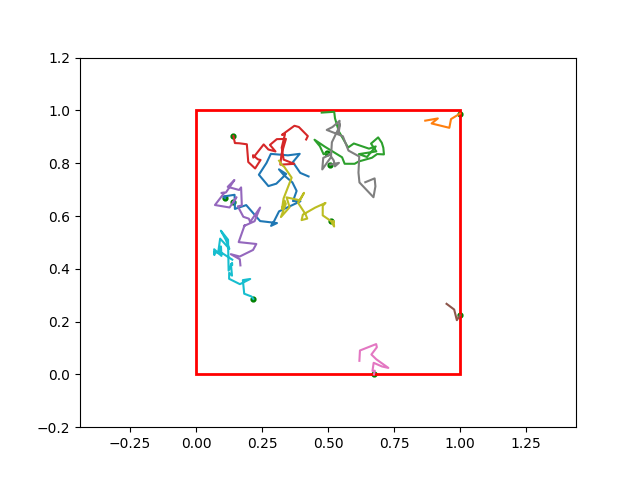

In [12]:
plt.cla()
for _ in range(10):
    path,xs,tfin=pde.simulate_interior_path(0.0,[np.random.uniform(),np.random.uniform()])
    plt.plot(path[:,1],path[:,2])
    plt.axis('equal')
    plt.scatter([path[:,1][-1]],[path[:,2][-1]],s=12,color='g')
rect = patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)
plt.xlim((-0.2,1.2))
plt.ylim((-0.2,1.2))
plt.show()
plt.grid()

In [13]:
def proyectar_adentro(X):
    x=X[0]
    y=X[1]
    if x<0.0:
        x=0.0
    elif x>1.0:
        x=1.0
    if y<0:
        y=0.0
    elif y>1.0:
        y=1.0
    return x,y
    
        
def simular_trayectoria(pde,X0,dt):
    t=0.0
    x=[X0[0]]
    y=[X0[1]]
    while t<=1:
        pos=torch.tensor([t,x[-1],y[-1]],requires_grad=True)
        u=pde.model(pos)
        alpha=-np.sqrt(pde.lambd)*torch.autograd.grad(u,pos)[0]
        xnew=x[-1]+2*pde.lambd*alpha[1]*dt+np.sqrt(2)*np.random.normal(loc=0.0,scale=np.sqrt(dt))
        ynew=y[-1]+2*pde.lambd*alpha[2]*dt+np.sqrt(2)*np.random.normal(loc=0.0,scale=np.sqrt(dt))
        xn,yn=proyectar_adentro([xnew,ynew])
        x.append(xn)
        y.append(yn)
        if abs(x[-1]-1.0)<1e-5 and y[-1]<0.2:
            break
        t+=dt
    return x,y        

In [ ]:
xm,ym=simular_trayectoria(pde,[0.1,0.9],0.0001)
figpla = plt.figure()
axpla = figpla.add_subplot(111)
axpla.plot(xm,ym)
axpla.axis('equal')

interactive(children=(FloatSlider(value=1.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

<function __main__.draw(t)>

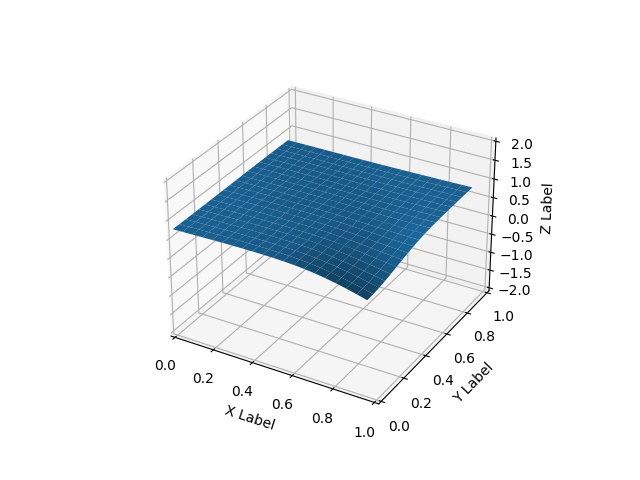

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(0, 1.0, 0.05)
X, Y = np.meshgrid(x, y)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(-5,5)

def draw(t):  
    ax.cla()
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_zlim(-2,2)
    times=t*np.ones(np.ravel(X).shape[0])
    tes=torch.tensor(np.stack((times,np.ravel(X), np.ravel(Y)),axis=1))
    zs =pde.model(tes).detach().numpy()
    Z = zs.reshape(X.shape)
    ax.plot_surface(X, Y, Z)

interact(draw,t=widgets.FloatSlider(min=0, max=1.0, step=0.01, value=10))